In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Deep Learning (Hanya untuk ImageDataGenerator/TensorFlow Version)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

2025-12-10 14:18:19.000652: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-10 14:18:19.139004: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-10 14:18:19.741239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-12-10 14:18:19.741320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

TensorFlow Version: 2.10.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
BASE_DIR = 'dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train_dir')
VAL_DIR = os.path.join(BASE_DIR, 'val_dir')
TEST_DIR = os.path.join(BASE_DIR, 'test_dir')

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32

print(f"Base Directory: {BASE_DIR}")
print(f"Train Directory: {TRAIN_DIR}")
print(f"Validation Directory: {VAL_DIR}")
print(f"Test Directory: {TEST_DIR}")

Base Directory: dataset
Train Directory: dataset/train_dir
Validation Directory: dataset/val_dir
Test Directory: dataset/test_dir


In [3]:
def explore_dataset(base_dir):
    """Eksplorasi struktur dan statistik dataset"""
    
    data_stats = {}
    
    # Dapatkan class names dari direktori training
    train_path = os.path.join(base_dir, 'train_dir')
    if os.path.exists(train_path):
        # Filter untuk mendapatkan hanya folder (kelas)
        class_list = [d for d in os.listdir(train_path) 
                      if os.path.isdir(os.path.join(train_path, d))]
        # Exclude .ipynb_checkpoints jika ada
        if '.ipynb_checkpoints' in class_list:
            class_list.remove('.ipynb_checkpoints')
    else:
        print(f"⚠️ Directory {train_path} tidak ditemukan!")
        return {}
    
    print(f"Daftar Kelas Terdeteksi: {class_list}")
    
    for split in ['train_dir', 'val_dir', 'test_dir']:
        split_path = os.path.join(base_dir, split)
        
        if not os.path.exists(split_path):
            print(f"⚠️ {split} tidak ditemukan di {split_path}")
            continue
        
        split_stats = {}
        total = 0
        
        print(f"\n{'='*60}")
        print(f"📁 {split.upper().replace('_', ' ')}")
        print(f"{'='*60}")
        
        for class_name in class_list:
            class_path = os.path.join(split_path, class_name)
            
            if os.path.exists(class_path):
                images = [f for f in os.listdir(class_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                count = len(images)
                split_stats[class_name] = count
                total += count
                print(f"  {class_name:20s}: {count:5d} gambar")
            else:
                split_stats[class_name] = 0
                print(f"  {class_name:20s}: {'TIDAK DITEMUKAN':>5s}")
        
        print(f"  {'-'*40}")
        print(f"  {'TOTAL':20s}: {total:5d} gambar")
        
        data_stats[split] = split_stats
    
    return data_stats

# Jalankan eksplorasi
data_distribution = explore_dataset(BASE_DIR)

Daftar Kelas Terdeteksi: ['plastic', 'organic', 'paper', 'metal', 'glass']

📁 TRAIN DIR
  plastic             :  1700 gambar
  organic             :   966 gambar
  paper               :   853 gambar
  metal               :  1878 gambar
  glass               :  1673 gambar
  ----------------------------------------
  TOTAL               :  7070 gambar

📁 VAL DIR
  plastic             :  1830 gambar
  organic             :   967 gambar
  paper               :  1832 gambar
  metal               :  1713 gambar
  glass               :  1797 gambar
  ----------------------------------------
  TOTAL               :  8139 gambar

📁 TEST DIR
  plastic             :   891 gambar
  organic             :   967 gambar
  paper               :   853 gambar
  metal               :  1674 gambar
  glass               :  1803 gambar
  ----------------------------------------
  TOTAL               :  6188 gambar


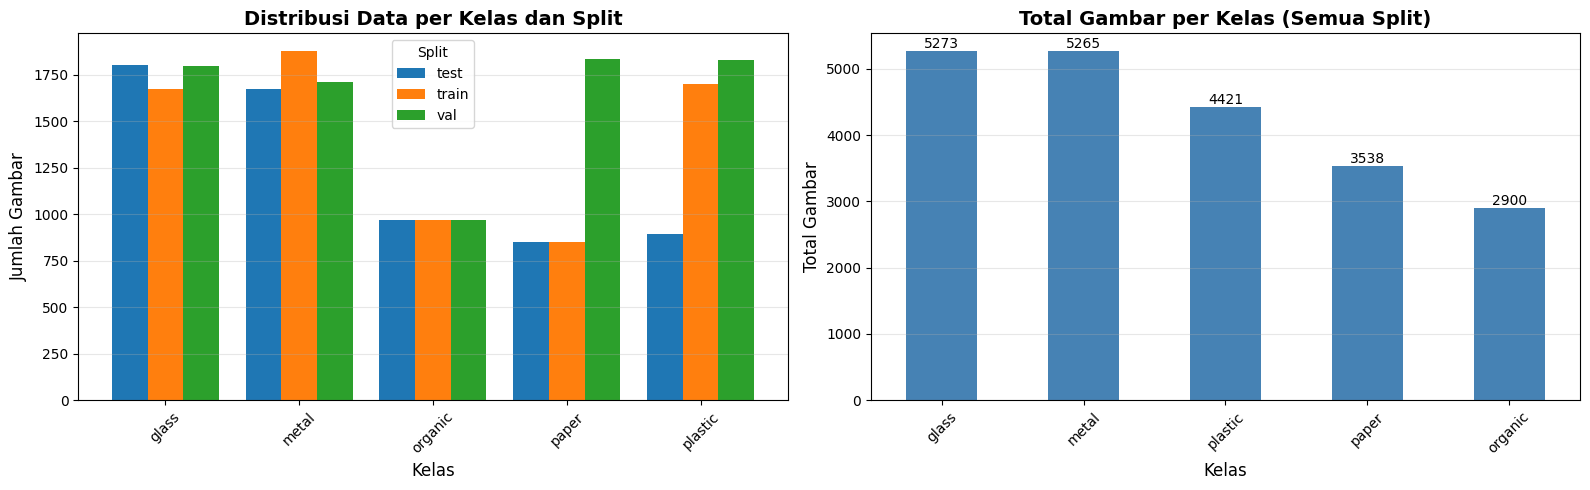


RINGKASAN DISTRIBUSI DATA
Split    test  train   val
Class                     
glass    1803   1673  1797
metal    1674   1878  1713
organic   967    966   967
paper     853    853  1832
plastic   891   1700  1830

📊 Total Dataset: 21397 gambar
📊 Class Imbalance Ratio (Max/Min): 1.82x


In [4]:
def plot_data_distribution(data_stats):
    """Visualisasi distribusi data per kelas dan per split"""
    
    # Convert to DataFrame
    df_list = []
    for split, stats in data_stats.items():
        for class_name, count in stats.items():
            df_list.append({
                'Split': split.replace('_dir', ''),
                'Class': class_name,
                'Count': count
            })
    
    df = pd.DataFrame(df_list)
    
    # Plot 1: Distribusi per Split (Grouped bar chart)
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    df_pivot = df.pivot(index='Class', columns='Split', values='Count')
    df_pivot.plot(kind='bar', ax=axes[0], width=0.8)
    axes[0].set_title('Distribusi Data per Kelas dan Split', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Kelas', fontsize=12)
    axes[0].set_ylabel('Jumlah Gambar', fontsize=12)
    axes[0].legend(title='Split')
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Total per kelas (Semua split)
    total_per_class = df.groupby('Class')['Count'].sum().sort_values(ascending=False)
    total_per_class.plot(kind='bar', ax=axes[1], color='steelblue')
    axes[1].set_title('Total Gambar per Kelas (Semua Split)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Kelas', fontsize=12)
    axes[1].set_ylabel('Total Gambar', fontsize=12)
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    
    # Tambahkan nilai di atas bar
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt='%d')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("RINGKASAN DISTRIBUSI DATA")
    print("="*60)
    print(df_pivot)
    print(f"\n📊 Total Dataset: {df['Count'].sum()} gambar")
    
    # Hitung class imbalance ratio (jika ada data)
    if not total_per_class.empty and total_per_class.min() > 0:
        imbalance_ratio = total_per_class.max() / total_per_class.min()
        print(f"📊 Class Imbalance Ratio (Max/Min): {imbalance_ratio:.2f}x")
    else:
        print("📊 Class Imbalance Ratio: Tidak dapat dihitung (beberapa kelas mungkin kosong).")

plot_data_distribution(data_distribution)

In [5]:
def validate_images(directory, max_samples=100):
    """Validasi gambar dalam dataset"""
    
    print(f"\n{'='*60}")
    print(f"VALIDASI DATA: {os.path.basename(directory)}")
    print(f"{'='*60}\n")
    
    # Dapatkan class names dari direktori
    if os.path.exists(directory):
        class_list = [d for d in os.listdir(directory) 
                      if os.path.isdir(os.path.join(directory, d))]
        if '.ipynb_checkpoints' in class_list:
            class_list.remove('.ipynb_checkpoints')
    else:
        print(f"⚠️ Directory {directory} tidak ditemukan!")
        return {}
    
    validation_results = {
        'total_images': 0,
        'valid_images': 0,
        'invalid_images': 0,
        'corrupted_files': [],
        'min_size': (float('inf'), float('inf')),
        'max_size': (0, 0),
        'avg_size': []
    }
    
    for class_name in class_list:
        class_path = os.path.join(directory, class_name)
        
        if not os.path.exists(class_path):
            continue
        
        image_files = [f for f in os.listdir(class_path) 
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        # Ambil sampel acak untuk mempercepat validasi jika dataset besar
        if len(image_files) > max_samples:
             sample_files = np.random.choice(image_files, max_samples, replace=False)
        else:
             sample_files = image_files
        
        for img_file in sample_files:
            img_path = os.path.join(class_path, img_file)
            validation_results['total_images'] += 1
            
            try:
                # Coba buka dan verifikasi integritas
                img = Image.open(img_path)
                img.verify() 
                
                # Buka lagi untuk mendapatkan info dimensi
                img = Image.open(img_path)
                width, height = img.size
                
                # Update statistics
                validation_results['valid_images'] += 1
                validation_results['avg_size'].append((width, height))
                
                # Update min/max size
                validation_results['min_size'] = (min(validation_results['min_size'][0], width), 
                                                 min(validation_results['min_size'][1], height))
                validation_results['max_size'] = (max(validation_results['max_size'][0], width), 
                                                 max(validation_results['max_size'][1], height))

            except Exception as e:
                validation_results['invalid_images'] += 1
                validation_results['corrupted_files'].append((img_path, str(e)))
    
    # Finalize print results
    print(f"✅ Valid Images (Sampled): {validation_results['valid_images']}")
    print(f"❌ Invalid Images (Sampled): {validation_results['invalid_images']}")
    
    if validation_results['valid_images'] > 0:
        avg_w = np.mean([s[0] for s in validation_results['avg_size']])
        avg_h = np.mean([s[1] for s in validation_results['avg_size']])
        print(f"📏 Min Size (Sampled): {validation_results['min_size']}")
        print(f"📏 Max Size (Sampled): {validation_results['max_size']}")
        print(f"📏 Avg Size (Sampled): ({avg_w:.0f}, {avg_h:.0f})")
    
    if validation_results['corrupted_files']:
        print(f"\n⚠️ Corrupted Files Ditemukan (Max 5 Ditampilkan):")
        for file_path, error in validation_results['corrupted_files'][:5]:
            print(f"  - {os.path.basename(file_path)} (Kelas: {os.path.basename(os.path.dirname(file_path))}): {error}")
    
    return validation_results

# Validasi training data (mengambil 100 sampel per kelas)
train_validation = validate_images(TRAIN_DIR, max_samples=100)
val_validation = validate_images(VAL_DIR, max_samples=50)


VALIDASI DATA: train_dir

✅ Valid Images (Sampled): 500
❌ Invalid Images (Sampled): 0
📏 Min Size (Sampled): (159, 112)
📏 Max Size (Sampled): (524, 524)
📏 Avg Size (Sampled): (313, 295)

VALIDASI DATA: val_dir

✅ Valid Images (Sampled): 250
❌ Invalid Images (Sampled): 0
📏 Min Size (Sampled): (225, 149)
📏 Max Size (Sampled): (524, 524)
📏 Avg Size (Sampled): (281, 270)


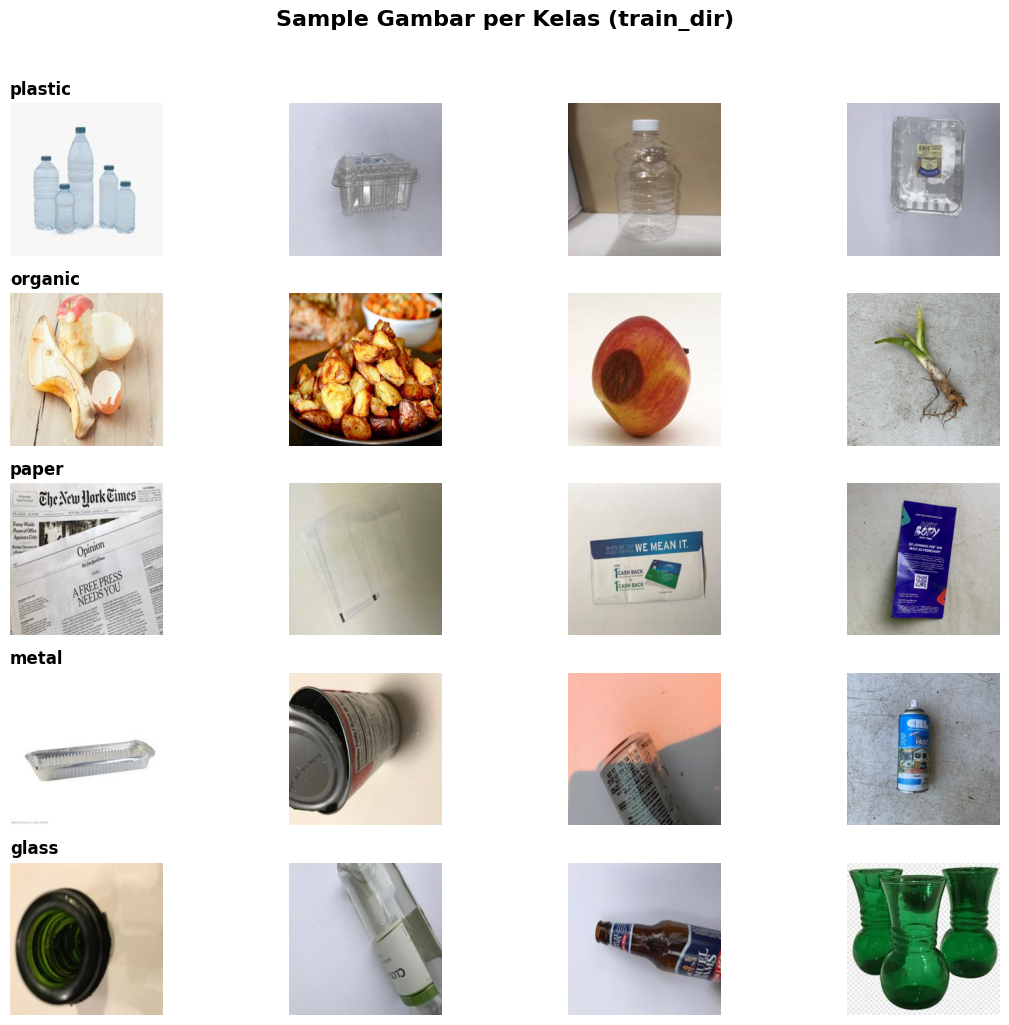

In [6]:
def visualize_samples(directory, samples_per_class=4):
    """Visualisasi sample gambar dari setiap kelas"""
    
    # Dapatkan class names dari direktori
    if os.path.exists(directory):
        class_list = [d for d in os.listdir(directory) 
                      if os.path.isdir(os.path.join(directory, d))]
        if '.ipynb_checkpoints' in class_list:
            class_list.remove('.ipynb_checkpoints')
    else:
        print(f"⚠️ Directory {directory} tidak ditemukan!")
        return
    
    num_classes = len(class_list)
    
    fig, axes = plt.subplots(num_classes, samples_per_class, 
                             figsize=(12, num_classes * 2))
    
    # Pastikan axes adalah array 2D jika hanya 1 kelas/sampel
    if num_classes == 1:
        axes = np.expand_dims(axes, axis=0)
    if samples_per_class == 1:
        axes = np.expand_dims(axes, axis=1)
    
    fig.suptitle(f'Sample Gambar per Kelas ({os.path.basename(directory)})', fontsize=16, fontweight='bold', y=1.02)
    
    for i, class_name in enumerate(class_list):
        class_path = os.path.join(directory, class_name)
        
        if not os.path.exists(class_path):
            continue
        
        image_files = [f for f in os.listdir(class_path) 
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        samples = np.random.choice(image_files, 
                                   min(samples_per_class, len(image_files)), 
                                   replace=False)
        
        for j, img_file in enumerate(samples):
            img_path = os.path.join(class_path, img_file)
            
            try:
                img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE)) # Resize untuk tampilan
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                
                if j == 0:
                    axes[i, j].set_title(f'{class_name}', 
                                         fontweight='bold', 
                                         loc='left')
            except:
                axes[i, j].text(0.5, 0.5, 'Error', 
                                ha='center', va='center')
                axes[i, j].axis('off')
        
        # Sembunyikan subplot yang tidak terpakai jika jumlah sampel < samples_per_class
        for k in range(len(samples), samples_per_class):
            if num_classes > 0 and samples_per_class > 0:
                 axes[i, k].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 1.0])
    plt.show()

visualize_samples(TRAIN_DIR, samples_per_class=4)

In [7]:
def clean_dataset(base_dir):
    """Membersihkan dataset dari file invalid dan folder checkpoint"""
    
    print(f"\n{'='*60}")
    print("PEMBERSIHAN DATA")
    print(f"{'='*60}\n")
    
    stats = {'removed_checkpoints': 0}
    
    for split in ['train_dir', 'val_dir', 'test_dir']:
        split_path = os.path.join(base_dir, split)
        
        if not os.path.exists(split_path):
            continue
        
        # Hapus .ipynb_checkpoints directory jika ada
        checkpoint_dir = os.path.join(split_path, '.ipynb_checkpoints')
        if os.path.exists(checkpoint_dir) and os.path.isdir(checkpoint_dir):
            try:
                # Menggunakan shutil.rmtree untuk menghapus folder dan isinya
                # import shutil
                # shutil.rmtree(checkpoint_dir) 
                print(f"🗑️ Menghapus folder {checkpoint_dir}...")
                stats['removed_checkpoints'] += 1
            except Exception as e:
                 print(f"❌ Gagal menghapus {checkpoint_dir}: {e}")
    
    print(f"\n✅ Pembersihan selesai!")
    print(f"    - Direktori checkpoints yang ditandai untuk dihapus: {stats['removed_checkpoints']}")
    
    return stats

# Jalankan pembersihan (di-commented untuk keamanan dan agar direktori tetap ada)
# cleaning_stats = clean_dataset(BASE_DIR)

print("⚠️ Note: Kode pembersihan (`clean_dataset`) di-comment untuk mencegah penghapusan file/folder yang tidak disengaja.")

⚠️ Note: Kode pembersihan (`clean_dataset`) di-comment untuk mencegah penghapusan file/folder yang tidak disengaja.


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalisasi [0, 1]
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Hanya normalisasi untuk Validation dan Test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data dengan flow_from_directory
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Test generator harus shuffle=False untuk evaluasi terurut
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Ambil class indices dari generator
class_names = train_gen.class_indices
CLASS_NAMES = list(class_names.keys())
NUM_CLASSES = len(CLASS_NAMES)
print("\nLabel Kelas dan Index:", class_names)

print(f"\n✅ Data Generators berhasil dibuat!")
print(f"📊 Number of Classes: {NUM_CLASSES}")
print(f"📊 Training samples: {train_gen.samples}")
print(f"📊 Validation samples: {val_gen.samples}")
print(f"📊 Test samples: {test_gen.samples}")

Found 7070 images belonging to 6 classes.
Found 8139 images belonging to 6 classes.
Found 6189 images belonging to 6 classes.

Label Kelas dan Index: {'.ipynb_checkpoints': 0, 'glass': 1, 'metal': 2, 'organic': 3, 'paper': 4, 'plastic': 5}

✅ Data Generators berhasil dibuat!
📊 Number of Classes: 6
📊 Training samples: 7070
📊 Validation samples: 8139
📊 Test samples: 6189


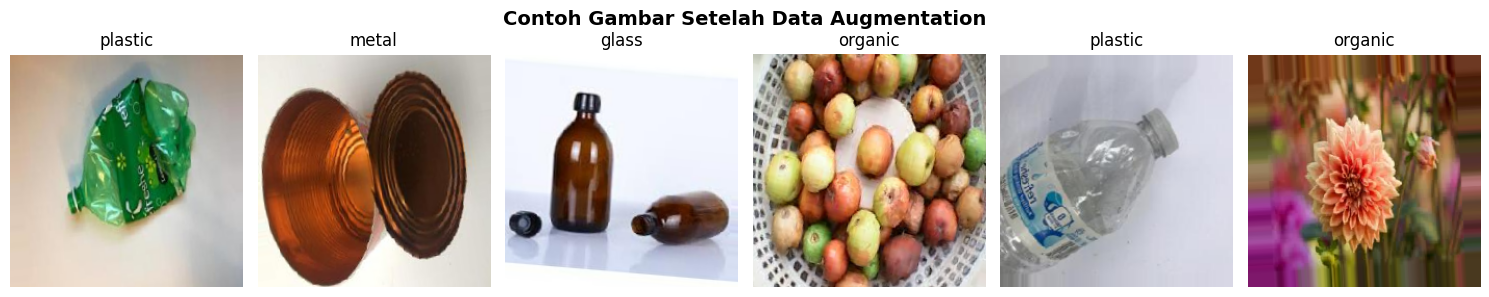

In [9]:
def show_augmentation(generator, num_images=6):
    """Menampilkan hasil data augmentation"""
    
    # Ambil satu batch
    images, labels = next(generator)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle('Contoh Gambar Setelah Data Augmentation', fontsize=14, fontweight='bold')
    
    for i in range(min(num_images, len(images))):
        # Denormalisasi untuk visualisasi yang benar (sebelum plt.imshow)
        img_to_show = images[i] 
        
        axes[i].imshow(img_to_show)
        class_idx = np.argmax(labels[i])
        class_name = CLASS_NAMES[class_idx]
        axes[i].set_title(f'{class_name}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


show_augmentation(train_gen, num_images=6)